# Import Statements

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

---

In [180]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

# Radial Basis Function

We use the Kernel Ridge Regression Model from scikit-learn.

In [181]:
def rbf_ridge_model(sigma, alpha):
    rbf_ridge = KernelRidge(alpha=alpha, kernel=RBF(sigma))
    rbf_ridge.fit(X_train, y_train)
    
    return rbf_ridge

The function *calc_errors* calculates the Mean Squared Error for the model above using different values for bandwidth $\sigma$ and the regularization parameter $\alpha$.  
These values are determined by *sigma_range* and *alpha_range*.  
It returns a dataframe with the used alpha_range as columns and sigma_range as index. The cells contain the corresponding mean squared error on the validation data.

In [182]:
def calc_errors(sigma_range, alpha_range):
    sigma_length = len(sigma_range)
    alpha_length = len(alpha_range)

    errors_arr = np.empty((sigma_length, alpha_length))
    for i, sigma in enumerate(sigma_range):
        for j, alpha in enumerate(alpha_range):
            errors_arr[i][j] = mean_squared_error(rbf_ridge_model(sigma, alpha).predict(X_val), y_val)
    
    errors = pd.DataFrame(errors_arr, columns = alpha_range, index = sigma_range)

    return errors.sort_index(ascending=False)

The function *split_data* splits the given dataset in train, hold and test datasets of respective sizes of 50%, 20% and 30%.

In [183]:
def split_data(X, y):
    # Do a 50-50 split first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=34)

    # Now split X_test to achive 50-20-30 split
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=(0.2/0.5),random_state=34)

    for name, data in {'train': X_train, 'validation': X_val, 'test': X_test}.items():
        print("""{}
        {} entries
        ~{:.2f}% of total data

        """.format(name, len(data), len(data)/len(X)))
        
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [184]:
def evaluate_model(model):
    mse = mean_squared_error(model.predict(X_test), y_test)
    mae = mean_absolute_error(model.predict(X_test), y_test)
    r2 = r2_score(model.predict(X_test), y_test)

    print("""Evaluation of model

    Mean-Squared-Error:             {:8.4f}
    Mean-Absolute-Error:            {:8.4f}
    
    Coefficient of determination:   {:8.4f} %
    """.format(mse, mae, r2*100))

## Marburg

We start by preparing the dataframe.  
First we resample the given data hourly.  
Then we extract some time related features from the datetime index and merge the resulting dataframe witht the weather data.

In [185]:
# peak demand
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True)

In [186]:
X = ma[['temperature', 'hour', 'precipitation', 'dayofyear']].values
y = ma['demand'].values

In [187]:
X_train, X_val, X_test, y_train, y_val, y_test  = split_data(X,y)

train
        4392 entries
        ~0.50% of total data

        
validation
        1757 entries
        ~0.20% of total data

        
test
        2635 entries
        ~0.30% of total data

        


### Disclaimer

We have marked multiple cells in the following code with **### LONG PROCESSESING OPERATION ###**. This means that the runtime of these cells can take several minutes (~10 minutes per cell on our systems). This is because we try to tweak our parameters with a grid search algorithm. However for this grid search we did not use preimplemented functions, but we wrote them oursevlves. Thereby our self-written functions do not make use of multiple threads and are not efficient. 
All cells are prerun and the output should already be there. It is thereby not necessery to rerun all cells.

### Alpha & Sigma Range 1

We will now used the functions we defined above to find a good regression model.
We start by guessing an initial set of sigma and alphas.

In [188]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)

### LONG PROCESSING OPERATION ###
ma_errors_1 = calc_errors(sigma_range, alpha_range)

In [189]:
ma_vmin_1 = ma_errors_1.values.min()
ma_vmin_1

58.34908476221663

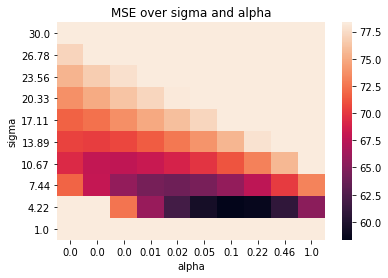

In [190]:
ax = sns.heatmap(ma_errors_1, vmin=ma_vmin_1, vmax=ma_vmin_1+20,
                 xticklabels=ma_errors_1.columns.values.round(2),
                 yticklabels=ma_errors_1.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

We will now go on by fitting our sigma and alpha ranges to the results as seen above.  
Basically we 'zoom' into the dark zone, where the mean squared error is the lowest.

### Alpha & Sigma Range 2

In [191]:
sigma_range = np.linspace(1, 8, 10)
alpha_range = np.logspace(-2, -0.5, 10)
    
### LONG PROCESSING OPERATION ###
ma_errors_2 = calc_errors(sigma_range, alpha_range)

In [192]:
ma_vmin_2 = ma_errors_2.values.min()
ma_vmin_2

56.72597902047088

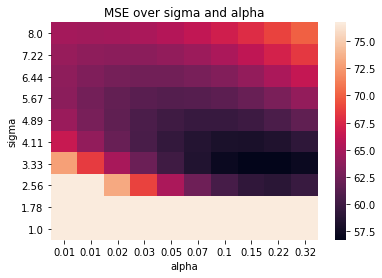

In [193]:
ax = sns.heatmap(ma_errors_2, vmin=ma_vmin_2, vmax=ma_vmin_2+20,
                 xticklabels=ma_errors_2.columns.values.round(2),
                 yticklabels=ma_errors_2.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 3

In [194]:
sigma_range = np.linspace(2, 5, 10)
alpha_range = np.logspace(-1, -0.5, 10)

### LONG PROCESSING OPERATION ###
ma_errors_3 = calc_errors(sigma_range, alpha_range)

In [195]:
ma_vmin_3 = errors_3.values.min()
ma_vmin_3

56.66991594567819

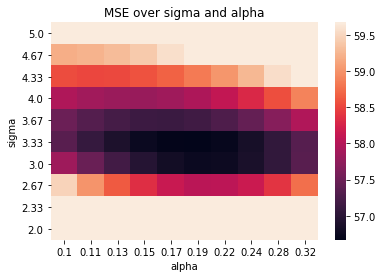

In [196]:
ax = sns.heatmap(ma_errors_3, vmin=ma_vmin_3, vmax=ma_vmin_3+3,
                 xticklabels=ma_errors_3.columns.values.round(2),
                 yticklabels=ma_errors_3.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

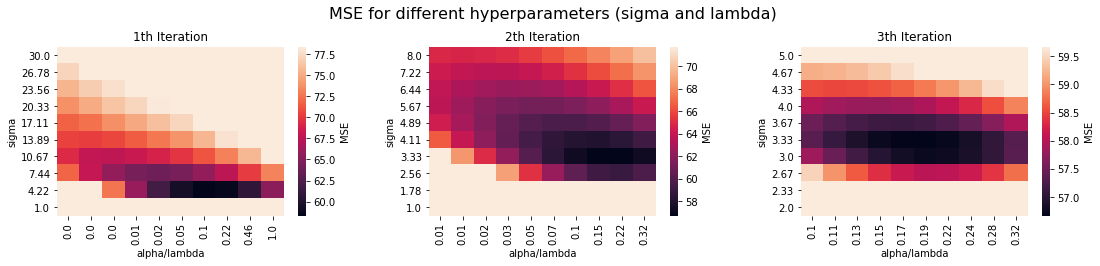

In [197]:
fig,axes = plt.subplots(nrows=1, ncols=3 ,figsize=(16,4)) 

data = [ma_errors_1, ma_errors_2, ma_errors_3]
color_range = [20, 15, 3]

for i, ax in enumerate(axes):
    vmin = data[i].values.min()
    ax = sns.heatmap(data[i], vmin=vmin, vmax=vmin+color_range[i],
                 xticklabels=data[i].columns.values.round(2),
                 yticklabels=data[i].index.values.round(2), ax=ax,
                cbar_kws={'label': 'MSE'})
    ax.set_ylabel('sigma')
    ax.set_xlabel('alpha/lambda')
    ax.set_title('{}th Iteration'.format(i+1))

fig.suptitle('MSE for different hyperparameters (sigma and lambda)', fontsize=16)

fig.tight_layout(pad=3)

plt.show()

---

We now print out our approximation of the best hyperparameters, as well as the mean squared error of the validation data set.

In [198]:
ma_errors_3_arr = ma_errors_3.values
best_sigma_ind, best_alpha_ind = np.unravel_index(ma_errors_3_arr.argmin(), ma_errors_3_arr.shape)
best_alpha = ma_errors_3.columns[best_alpha_ind]
best_sigma = ma_errors_3.index[best_sigma_ind]

print("""Tweaked Hyperparameters:
sigma: ~{:.4}
alpha: ~{:.4f}

Mean-Squared-Error: {}
""".format(best_sigma, best_alpha, ma_errors_3_arr.min()))

Tweaked Hyperparameters:
sigma: ~3.333
alpha: ~0.1896

Mean-Squared-Error: 56.66991594567819



Now we evaluate our resulting model on the test data set

In [199]:
# tweaked_model = rbf_ridge_model(best_sigma, best_alpha)
# hard-coded to prevent rerunning all the time
tweaked_model = rbf_ridge_model(3.333333333333333, 0.1895735652406376)
evaluate_model(tweaked_model)

Evaluation of model

    Mean-Squared-Error:              57.4553
    Mean-Absolute-Error:              5.4919
    
    Coefficient of determination:    69.1785 %
    


## Duisburg

We do the exact same procedure for Duisburg as we did above for Marburg

In [200]:
# peak demand
du = pd.DataFrame(duisburg.resample('H').count()["day"])
du.rename(columns={'day': 'demand'}, inplace=True)

du['dayofyear'] = du.index.map(lambda datetime : datetime.dayofyear)
du['week'] = du.index.map(lambda datetime : datetime.week)
du['weekday'] = du.index.map(lambda datetime : datetime.weekday)
du['is_weekday'] = du['weekday'].map(lambda day : day < 5)
du['hour'] = du.index.map(lambda datetime : datetime.hour)

du = du.merge(duisburg_weather, left_index=True, right_index=True)

In [201]:
X = du[['temperature', 'hour', 'precipitation', 'dayofyear']].values
y = du['demand'].values

In [202]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

train
        4392 entries
        ~0.50% of total data

        
validation
        1757 entries
        ~0.20% of total data

        
test
        2635 entries
        ~0.30% of total data

        


### Alpha & Sigma Range 1

In [203]:
sigma_range = np.linspace(1, 30, 10)
alpha_range = np.logspace(-3, 0, 10)

### LONG PROCESSING OPERATION ###
du_errors_1 = calc_errors(sigma_range, alpha_range)

In [204]:
du_vmin_1 = errors_1.values.min()
du_vmin_1

58.34908476221663

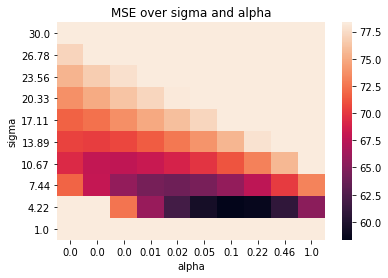

In [205]:
ax = sns.heatmap(errors_1, vmin=du_vmin_1, vmax=du_vmin_1+20,
                 xticklabels=du_errors_1.columns.values.round(2),
                 yticklabels=du_errors_1.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 2

In [206]:
sigma_range = np.linspace(1, 8, 10)
alpha_range = np.logspace(-2, -0.5, 10)

### LONG PROCESSING OPERATION ###
du_errors_2 = calc_errors(sigma_range, alpha_range)

In [207]:
du_vmin_2 = du_errors_2.values.min()
du_vmin_2

50.261427199106

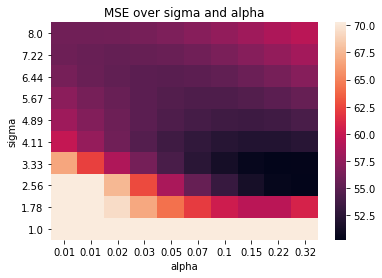

In [208]:
ax = sns.heatmap(du_errors_2, vmin=du_vmin_2, vmax=du_vmin_2+20,
                 xticklabels=du_errors_2.columns.values.round(2),
                 yticklabels=du_errors_2.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

### Alpha & Sigma Range 3

In [209]:
sigma_range = np.linspace(3, 4, 10)
alpha_range = np.logspace(-1, -0.5, 10)

### LONG PROCESSING OPERATION ###
du_errors_3 = calc_errors(sigma_range, alpha_range)

In [218]:
du_vmin_3 = du_errors_3.values.min()
du_vmin_3

49.84015306061111

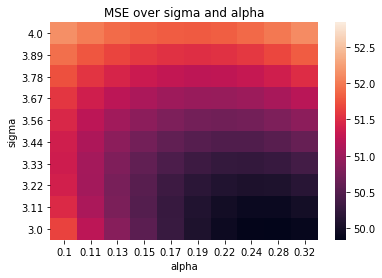

In [221]:
ax = sns.heatmap(du_errors_3, vmin=du_vmin_3, vmax=du_vmin_3+3,
                 xticklabels=du_errors_3.columns.values.round(2),
                 yticklabels=du_errors_3.index.values.round(2))
ax.set_xlabel('alpha')
ax.set_ylabel('sigma') 
ax.set_title('MSE over sigma and alpha')

plt.show()

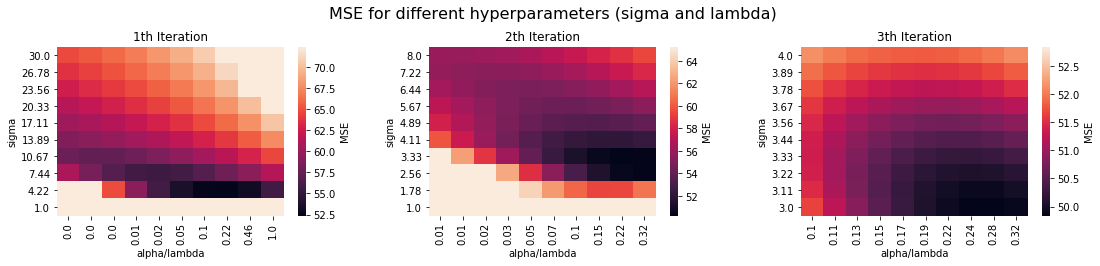

In [220]:
fig,axes = plt.subplots(nrows=1, ncols=3 ,figsize=(16,4)) 

data = [du_errors_1, du_errors_2, du_errors_3]
color_range = [20, 15, 3]

for i, ax in enumerate(axes):
    vmin = data[i].values.min()
    ax = sns.heatmap(data[i], vmin=vmin, vmax=vmin+color_range[i],
                 xticklabels=data[i].columns.values.round(2),
                 yticklabels=data[i].index.values.round(2), ax=ax,
                cbar_kws={'label': 'MSE'})
    ax.set_ylabel('sigma')
    ax.set_xlabel('alpha/lambda')
    ax.set_title('{}th Iteration'.format(i+1))

fig.suptitle('MSE for different hyperparameters (sigma and lambda)', fontsize=16)

fig.tight_layout(pad=3)

plt.show()

---

In [213]:
du_errors_3_arr = du_errors_3.values
best_sigma_ind, best_alpha_ind = np.unravel_index(du_errors_3_arr.argmin(), du_errors_3_arr.shape)
best_alpha = du_errors_3.columns[best_alpha_ind]
best_sigma = du_errors_3.index[best_sigma_ind]

print("""Tweaked Hyperparameters:
sigma: ~{:.4f}
alpha: ~{:.4f}

Mean-Squared-Error: {}
""".format(best_sigma, best_alpha, errors_3_arr.min()))

Tweaked Hyperparameters:
sigma: ~3.0000
alpha: ~0.2783

Mean-Squared-Error: 56.66991594567819



In [214]:
tweaked_model = rbf_ridge_model(3.222, 0.1896)
evaluate_model(tweaked_model)

Evaluation of model

    Mean-Squared-Error:              49.9636
    Mean-Absolute-Error:              5.0485
    
    Coefficient of determination:    60.8807 %
    
